In [1221]:
import math
import numpy
import random

In [1222]:
class Value:
    def __init__(self, data, children=(), op="", label=""):
        self.data = data
        self.children = set(children)
        self.op = op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value( Data: {self.data} )"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, children=(self, other), op="+")
        def _backward():
            
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, children=(self, other), op="*")
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int and float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.children:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [1223]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir" : "LR"}) # LR = Left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangle {"record"} node for it
        dot.node(name=uid, label= "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape="record" )
        if n.op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n.op, label=n.op)
            # and connect this node to it
            dot.edge(uid + n.op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)

    return dot

In [1224]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"
L

Value( Data: -8.0 )

In [1225]:
# Using the Chain rule principle, i.e (dz/dx) = (dz/dy) * (dy/dx)

L.grad = 1
f.grad = L.grad * d.data
d.grad = L.grad * f.data
e.grad = d.grad * 1
c.grad = d.grad * 1
a.grad = e.grad * b.data
b.grad = e.grad * a.data

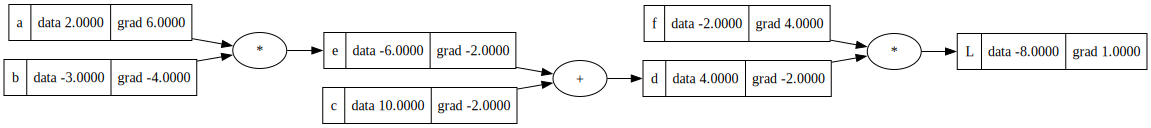

In [1226]:
draw_dot(L)

In [1227]:
# Input x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# Weights x1, x2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# Bias for the neuron
b = Value(6.8813735870255432, label="b")

# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

o.backward()


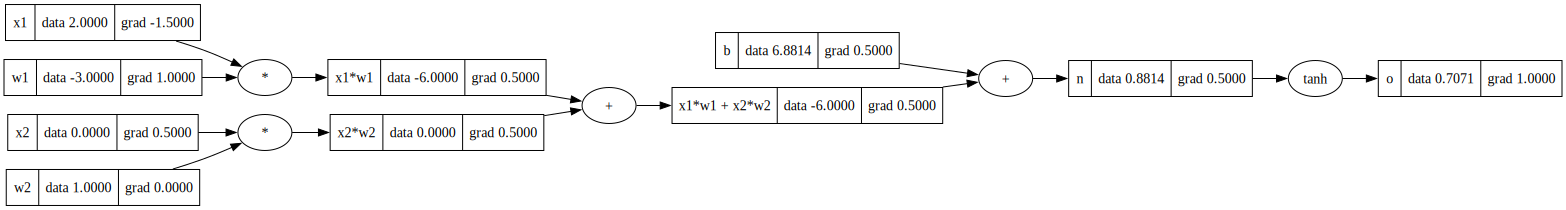

In [1228]:
draw_dot(o)

In [1229]:
# Manually implementing back propagation by calculation
# Using the Chain rule principle, i.e (dz/dx) = (dz/dy) * (dy/dx)

# o.grad = 1
# n.grad = 1 - o.data**2
# b.grad = n.grad * 1
# x1w1x2w2.grad = n.grad * 1
# x1w1.grad  = x1w1x2w2.grad * 1
# x2w2.grad  = x1w1x2w2.grad * 1
# x1.grad = x1w1.grad * w1.data
# w1.grad = x1w1.grad * x1.data
# x2.grad = x2w2.grad * w2.data
# w2.grad = x2w2.grad * x2.data

In [1230]:
# Sequentially implementing back propagation with the _backward function

# o.grad = 1.0
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

In [1231]:
# Implementing the _backward function for back propagation on a topological graph

# o.grad = 1.0

# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v.children:
#             build_topo(child)
#         topo.append(v)
# build_topo(o)

# for child in reversed(topo):
#     child._backward

In [1232]:
# Recursively implementing the _backward function for back propagation

# def backward_prop(value):
#     value._backward()
#     for n in value.children:
#         backward_prop(n)

# o.grad = 1
# backward_prop(o)

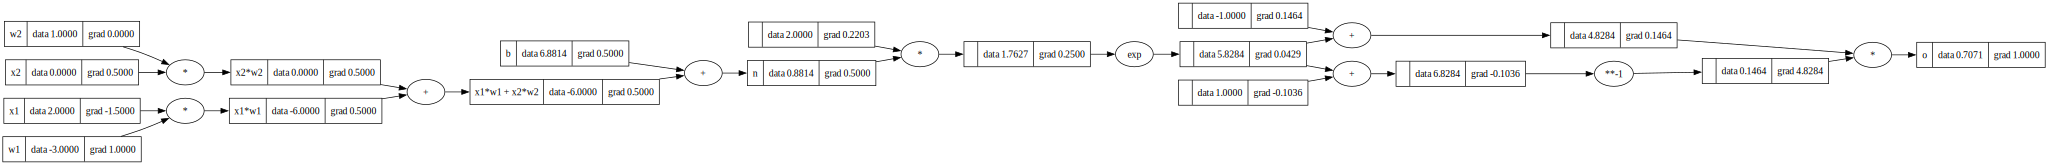

In [1233]:
# Input x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# Weights x1, x2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# Bias for the neuron
b = Value(6.8813735870255432, label="b")

# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"

# Performing tanh expanded
# o = n.tanh()
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = "o"

o.backward()

draw_dot(o)

In [1234]:
import torch

In [1235]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870255432]).double()
b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [1236]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((w1*x1 for w1, x1 in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def _parameters(self):
        return self.w + [self.b]
    

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def _parameters(self):
        ret = []
        for neuron in self.neurons:
            ret.extend(neuron._parameters())
        return ret


class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def _parameters(self):
        ret = []
        for layer in self.layers:
            ret.extend(layer._parameters())
        return ret
    

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value( Data: 0.553924948671125 )

In [1237]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, -0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [-1.0, 1.0, -1.0, 1.0]

In [1238]:
# Starting learning rate
slr = 0.3
lr = slr

# Gradient Descent
epochs = 200
for i in range(epochs):

    # Forward Parse
    ypred = [n(x) for x in xs]
    loss = sum([(yhat - y)**2 for y, yhat in zip(ys, ypred)], start=Value(0))

    # Backward Parse
    for p in n._parameters():
        p.grad = 0.0
    loss.backward()

    # Update Parameters
    # Making the learning smaller on each iteration of GD
    # lr = slr / (i + 1)
    lr = (slr / 100) * (((epochs - i) / epochs) * 100)
    for p in n._parameters():
        p.data += -lr * p.grad

    print(i+1, loss.data)

1 6.054537441375855
2 7.5801426653475
3 6.145106901495618
4 7.781819524077844
5 7.399354682459736
6 4.262814572275159
7 7.6631236241681675
8 6.888733952442915
9 4.910618980241986
10 7.828227196849744
11 7.691236950681783
12 7.123301610959039
13 2.8696045415335627
14 3.9620604241939437
15 2.229760086277018
16 3.845120443578344
17 3.6109986968238146
18 2.9196225266582476
19 3.2204998523504127
20 4.0076846743519665
21 3.927427691761363
22 3.7301213041922896
23 3.5343626049666965
24 3.696649107199913
25 1.2128975554919326
26 5.824517899697881
27 3.828559101360059
28 3.657595107906783
29 2.907222215601223
30 4.22531413683588
31 3.9188582738884037
32 3.888238529517065
33 3.829989260766622
34 3.690236034541382
35 3.1849181809592237
36 1.8900978703745754
37 3.2208088385706475
38 1.3509602677775494
39 3.8717522964325815
40 3.788828635589201
41 3.551379325927119
42 2.525680074378776
43 3.7786479846655348
44 3.578908194517884
45 3.748448063742318
46 0.0009402728181179996
47 0.0009223021235043999


In [1239]:
ypred

[Value( Data: -0.9909085950100394 ),
 Value( Data: 0.9942712500933526 ),
 Value( Data: -0.9980815489588952 ),
 Value( Data: 0.983176916535534 )]